In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# Internal packages
from data_loader import KidneyStoneDataset, ToTensor
from model import cont_rec_ks_net, binary_neg_loglik, cont_rec_neg_loglik, ContinuousOutcome
from train import train

In [2]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS     = 150
LEARN_R    = 1e-2
N_HU       = 4
#NLA = F.relu
NLA = nn.LeakyReLU(1) # For a linear neural network

# Initialize the dataset
data = KidneyStoneDataset("./data/ks_cont_rec_data.npy", transform=ToTensor())
train_loader = DataLoader(data, batch_size=BATCH_SIZE)

# Initialize the model
model = ContinuousOutcome([N_HU], NLA)

# Optimizers
#optimizer = optim.SGD(model.parameters(), lr=LEARN_R, weight_decay=0.1)
optimizer = optim.RMSprop(model.parameters(), lr=LEARN_R)

In [4]:
cum_loss = train(model, optimizer, cont_rec_neg_loglik, train_loader, EPOCHS)

In [5]:
# We want to query an intervention on the treatment. In order to do that, we estimate p(R=1|L=1, T=do(A))*P(L=1)
l_1_t_1_r_1 = torch.tensor([1., 1., 1.])
l_0_t_1_r_1 = torch.tensor([0., 1., 1.])

# We want to query an intervention on the treatment. In order to do that, we estimate p(R=1|L=1, T=do(B))*P(L=1)
l_1_t_0_r_1 = torch.tensor([1., 0., 1.])
l_0_t_0_r_1 = torch.tensor([0., 0., 1.])

In [6]:
# Probabilities with Treatment A
p_ks, p_t1_l1, mu_r1_t1_l1, log_sigma_r1_t1_l1 = model(l_1_t_1_r_1.unsqueeze(0)) # Probabilities with KS = L
_, p_t1_l0, mu_r1_t1_l0, log_sigma_r1_t1_l0 = model(l_0_t_1_r_1.unsqueeze(0))    # Probabilities with KS = S

# Probabilities with Treatment B
_, p_t0_l1, mu_r1_t0_l1, log_sigma_r1_t0_l1 = model(l_1_t_0_r_1.unsqueeze(0))  # Probabilities with KS = L
_, p_t0_l0, mu_r1_t0_l0, log_sigma_r1_t0_l0 = model(l_0_t_0_r_1.unsqueeze(0))  # Probabilities with KS = S

In [7]:
print(mu_r1_t0_l0.item(), mu_r1_t1_l0.item()) # The first should be around 1, the second around 4

0.873916745185852 4.568049430847168


In [8]:
int_t1 = mu_r1_t1_l1*p_ks + mu_r1_t1_l0*(1-p_ks)
int_t0 = mu_r1_t0_l1*p_ks + mu_r1_t0_l0*(1-p_ks)

c_effect = int_t1 - int_t0
print(c_effect.item())

3.694132089614868


In [45]:
import matplotlib.pyplot as plt
import numpy as np

In [46]:
data = np.load("./data/ks_cont_rec_data.npy")

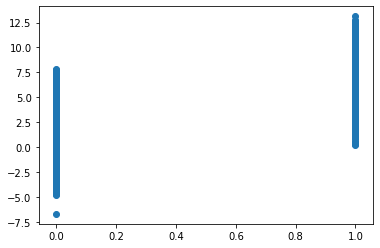

In [47]:
plt.scatter(data[:,1], data[:,2]);

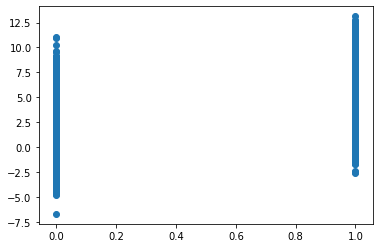

In [48]:
plt.scatter(data[:,0], data[:,2]);

In [49]:
p_r_b = np.mean(data[data[:,1]==False, 2]) # P(R=1 | B)
p_r_a = np.mean(data[data[:,1]==True, 2])  # P(R=1 | A)
print("is P(R=1 | B) > P(R=1 | A)?", p_r_b > p_r_a)

p_l = np.mean(data[:, 0]) # P(R=1 | B)

# Check that, individually, P(R=1 | A, S) > P(R=1 | B, S)
#   and P(R=1 | A, L) > P(R=1 | B, L)

mask_l_a = ((data[:,1]==True) & (data[:,0]==True))
p_r_l_a  = np.mean(data[mask_l_a, 2])               # P(R=1 | A, L)
print("P(R=1 | A, L) ", p_r_l_a)
mask_l_b = ((data[:,1]==False) & (data[:,0]==True))
p_r_l_b  = np.mean(data[mask_l_b, 2])               # P(R=1 | B, L)
print("P(R=1 | B, L) ", p_r_l_b)

mask_s_a = ((data[:,1]==True) & (data[:,0]==False))
p_r_s_a  = np.mean(data[mask_s_a, 2])               # P(R=1 | A, S)
print("P(R=1 | A, S) ", p_r_s_a)
mask_s_b = ((data[:,1]==False) & (data[:,0]==False))
p_r_s_b  = np.mean(data[mask_s_b, 2])               # P(R=1 | B, S)
print("P(R=1 | B, S) ", p_r_s_b)

is P(R=1 | B) > P(R=1 | A)? False
P(R=1 | A, L)  6.730615941108319
P(R=1 | B, L)  2.7399951033949397
P(R=1 | A, S)  5.051728588900619
P(R=1 | B, S)  1.0273448785795336


In [50]:
int_t1 = p_r_l_a*p_l + p_r_s_a*(1-p_l) 
int_t0 = p_r_l_b*p_l + p_r_s_b*(1-p_l) 

c_effect = int_t1 - int_t0
print(c_effect)

4.007866913041395
